In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import pandas as pd
import numpy as np

from src.VideoReader import VideoReader
from src.Video import Video
from src.histograms import compute_histograms
from src import preprocess as prep
import cv2
import os
from src.cvtools import ipynb_show_cv2_image
import random
import src.preprocess as prep

In [46]:
def find(target, videos):
    video_path = os.path.join(target + ".mp4")
    target_video = VideoReader()
    target_video.open(video_path)
    frames = target_video.get_frames()
    
    list_frames = list(frames)
#     todo: average per novelty section in video?
#     first_frame = list_frames[videos[1].segments[6].frame_start]
    random_frame = random.randint(1, len(list_frames))
    target_frame = list_frames[random_frame]
    ipynb_show_cv2_image(target_frame, 'target_frame')
    
    target_histograms = compute_histograms(target_frame)
    
    distances = []
    for video in videos:
        segment_dist = []       
        for segment in video.segments:
            dist = 0
            for h in range(len(segment.histograms[0])):
#                   Method kiezen, voor nu intersection
                dist += cv2.compareHist(target_histograms[0][h], segment.histograms[0][h], cv2.HISTCMP_INTERSECT)
            segment_dist.append(dist)
        
        distances.append(segment_dist)
    

    best_dist_indices = []
    for d in distances:
        best_dist_indices.append(np.argpartition(d, -5)[-5:])
    
    sub_distances = []
    i = 0
    for video in videos:
        segment_dist = []       
        for segment_index in best_dist_indices[i]:
            segment = video.segments[segment_index]
            
            dist = 0
            for i_sub_hist in range(1,5):
                nr_hists = len(target_histograms[0])
                for h in range(nr_hists):
                    dist += cv2.compareHist(target_histograms[i_sub_hist][h], segment.histograms[i_sub_hist][h], cv2.HISTCMP_INTERSECT)
                
            segment_dist.append(dist)    
        sub_distances.append(segment_dist)
        i = i + 1

    # Find index of maximum value in matrix
    result = np.where(sub_distances == np.amax(sub_distances))
    print(result)
    match_vid = result[0][0]
    match_seg = best_dist_indices[result[0][0]][result[1][0]]
    print('video {:05d} - segment {}'.format(match_vid+1, match_seg))

    
    matched_frame = list_frames[videos[match_vid].segments[match_seg].frame_start]
    ipynb_show_cv2_image(matched_frame, 'matched_frame')
    
    display('expected vid {} frame {} - found vid {:05d}, frame {}'.format(target, random_frame, match_vid +1, videos[match_vid].segments[match_seg].frame_start))
    

In [73]:
vids = prep.load_training_set(range(1, 4))
vids_list = list(vids)

(array([2]), array([3]))
video 00003 - segment 45


'expected vid data/movies/00003 frame 2554 - found vid 00003, frame 2566'

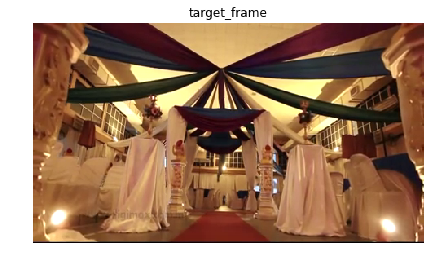

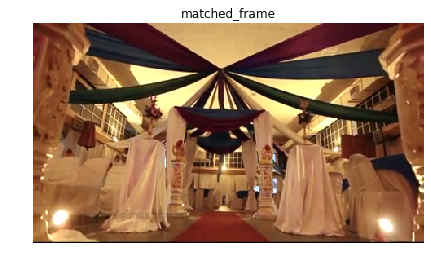

In [80]:
find(r'data/movies/00003', vids_list)